# 오픈 소스 


## 물체인식

#### 실시간 객체탐지 모델인 YOLO 모델을 학습시켜 객체를 인식한다. 

**1.YOLO란 ?** <br>

 학습한 물체의 종류와 위치를 실시간으로 파악 할 수 있는  Real-Time Object Detection 모델로 아래의 그림과 같은 아키텍쳐로 구성되어 있다. 
 
 `convolutional layer를 사용하였고 ResNet structure를 이용한 모델임을 알 수 있다.` 

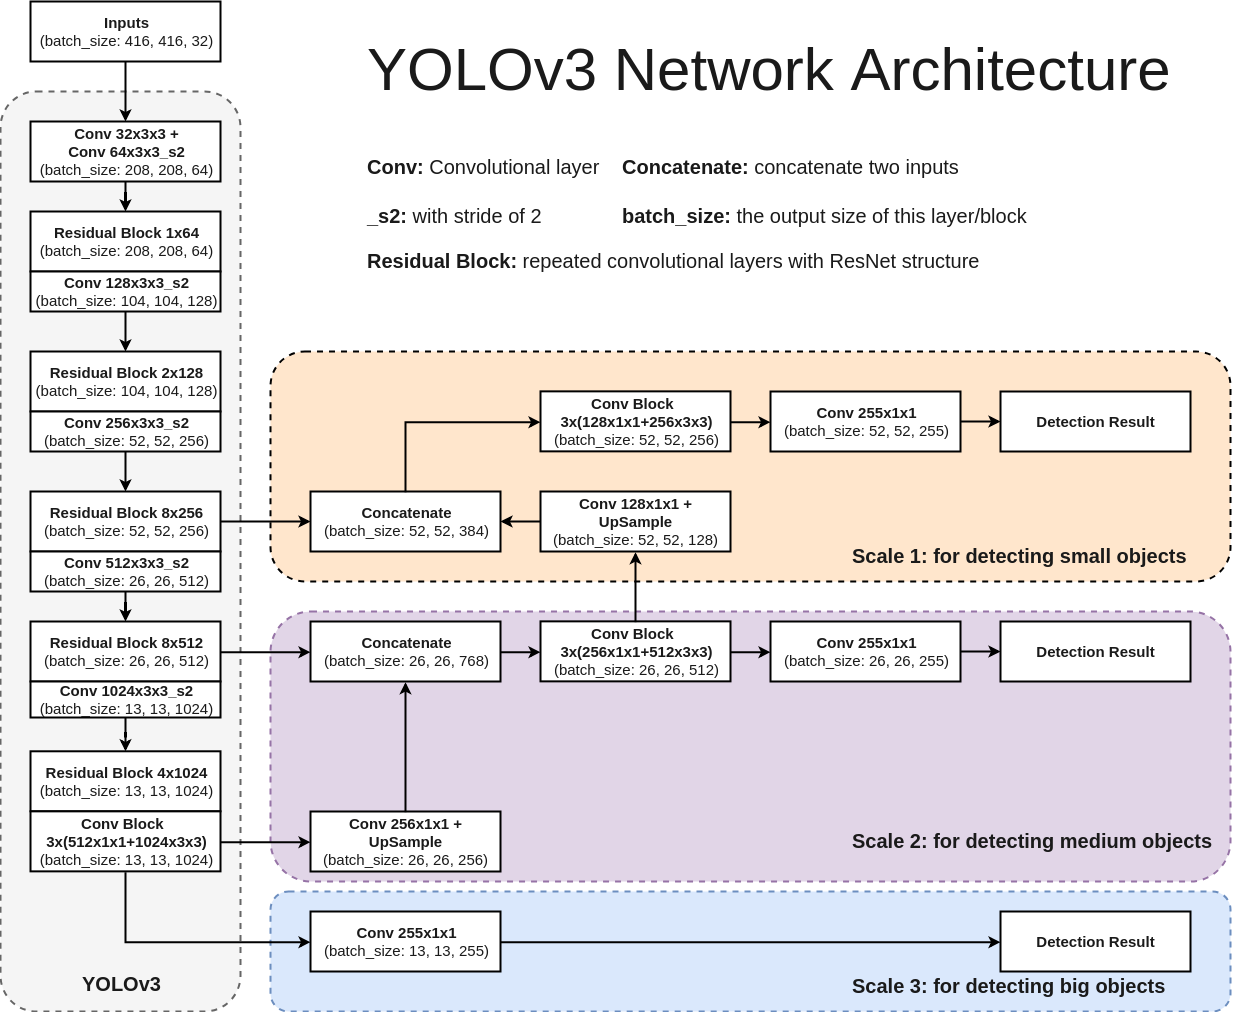

**모델의 원리**<br>
예측하고자 하는 이미지를 SXS Grid cells로 나누고 각 cell마다 하나의 객체를 예측한다. 그리고 미리 설정된 개수의 boundry boxes를 통해 객체의 위치와 크기를 파악한다. 이때, 각 cell마다 하나의 객체만을 예측할 수 있어 여러 객체가 겹쳐있을 경우 몇몇 객체는 탐지되지 않을 수 있다. 

    [cell이 예측하는 원리]
    
    - B개의 boundry boxes를 예측하고 각 box는 하나의 box confidence score을 가지고 있다.
    - 예측된 box 수에 관계없이 `단 하나`의 객체만 탐지한다.
    - C개의 conditional class probabilities 를 예측한다.

**2.YOLO Output** <br> 

YOLO 모델의 Output은 `N X N X (C + 5) X B)` 형태의 텐서를 반환하고 
이 정보를 이용하여 이미지 상에 존재하는 물체의 종류와 2D 좌표를 획득한다.

  - N X N : Grid
  - C : 학습한 Object 수 (Classes)
  - 5 : 탐지한 Object의 Bounding Box 정보 (x,y,w,h, confidence)
  - B : Grid cell당 박스 수 

**3.학습 데이터 준비**

 object Detection 모델을 만들기 위해서는 object가 담긴 `이미지`와 이미지 상의 오브젝트의 위치와 종류를 나타내는 `라벨`이 필요하다. 

1) Image Gathering 

 : 램프 on,램프 off,전구 on, 전구 off, 형광등의 총 5개의 클래스로 이루어진 이미지 5000장을 수집하여 활용한 모델이다. 

```python
import cv2
for i in range(len(videoFiles)):
    cam = cv2.VideoCapture(videoFile)
    currentFrame = 0
    while(True):
        ret, frame = cam.read()
        if ret:
            cv2.imwrite(currentFrame + '.jpg', frame)
            currentFrame += 1
        else:
            break
    cam.release()
```

2) Image Labeling 

 : `labelImg` 오픈소스 툴을 이용해 물체의 종류, 위치정보가 기록된 label생성
 (labelImg 는 이미지 상의 오브젝트의 위치와 종류를 xml형태로 반환한다.)

```
<annotation>
	<folder>lamp_on</folder>
	<filename>0.jpg</filename>
	<path>/lamp_on/0.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1920</width>
		<height>1080</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>lamp_on</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>704</xmin>
			<ymin>384</ymin>
			<xmax>970</xmax>
			<ymax>546</ymax>
		</bndbox>
	</object>
</annotation>
```

3) Image Resizing
 
  : 수집한 이미지의 원본 사이즈를 `Pillow` 라이브러리를 이용해 10분의 1 로 줄였다. 

```python 
# image resizing 

from PIL import Image
for image_file in images:
    image = Image.open(image_file)
    resize_image = image.resize((192, 108))
    resize_image.save(new_path)
    
# label resizing

def changeLabel(xmlPath, newXmlPath, imgPath, boxes):
    tree = elemTree.parse(xmlPath)

    # path 변경
    path = tree.find('./path')
    path.text = imgPath[0]

    # bounding box 변경
    objects = tree.findall('./object')
    for i, object_ in enumerate(objects):
        bndbox = object_.find('./bndbox')
        bndbox.find('./xmin').text = str(boxes[i][0])
        bndbox.find('./ymin').text = str(boxes[i][1])
        bndbox.find('./xmax').text = str(boxes[i][2])
        bndbox.find('./ymax').text = str(boxes[i][3])
    tree.write(newXmlPath, encoding='utf8')
```

4) Image Gathering 
  
  : 위에서 라벨링을 완료한 5천장의 이미지를 이용해 `horizontal filp` 을 사용하여 추가 이미지 1만장 생성

```python 
#horizontal filp 

import random
import numpy as np
class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, bboxes):
        img_center = np.array(img.shape[:2])[::-1]/2
        img_center = img_center.astype(int)
        img_center = np.hstack((img_center, img_center))
        if random.random() < self.p:
            img = img[:, ::-1, :]
            bboxes[:, [0, 2]] += 2*(img_center[[0, 2]] - bboxes[:, [0, 2]])
            box_w = abs(bboxes[:, 0] - bboxes[:, 2])
            bboxes[:, 0] -= box_w
            bboxes[:, 2] += box_w
        return img, bboxes
```

```python 
# label,image gathering 

for imgFile in imgFiles:
    fileName = imgFile.split('.')[0]
    label = f'{labelPath}{fileName}.xml'
    w, h = getSizeFromXML(label)

    # opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
    image = cv2.imread(imgPath + imgFile)[:,:,::-1]
    bboxes = getRectFromXML(classes, label)

    # HorizontalFlip image
    image, bboxes = RandomHorizontalFlip(1)(image.copy(), bboxes.copy())

    # Save image
    image = Image.fromarray(image, 'RGB')
    newImgPath = f'./data/light/image/train/{className}/'
    if not os.path.exists(newImgPath):
        os.makedirs(newImgPath)
    image.save(newImgPath + imgFile)

    # Save label
    newXmlPath = f'./data/light/label/train/{className}/'
    if not os.path.exists(newXmlPath):
        os.makedirs(newXmlPath)
    newXmlPath = newXmlPath + fileName + '.xml'
    changeLabel(label, newXmlPath, newImgPath, bboxes)
```

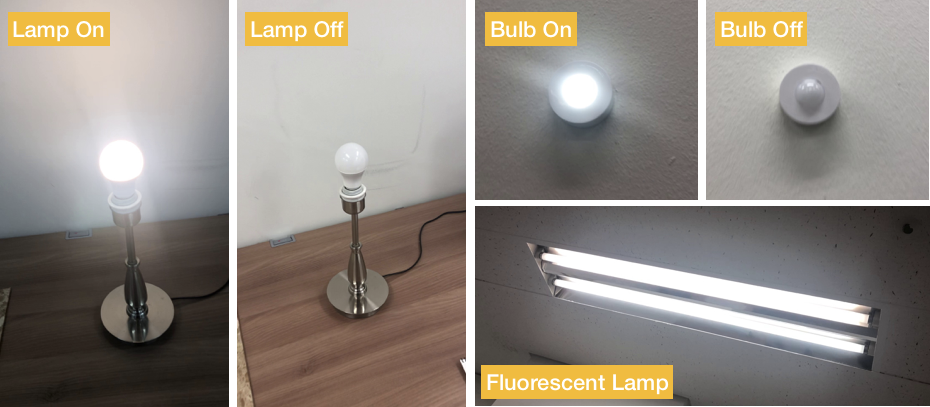

**4.YOLO Training**

`Keras3-yolo3` 라이브러리를 이용해 YOLO 모델을 학습시켰다. 
```python
wget https://pjreddie.com/media/files/yolov3-tiny.weights
```

1) Convert Darknet Model To Keras Model

  : c/c++로 구현된 Darknet 프레임워크를 `.h5` 포멧으로 `convert.py`파일을 이용해 변환한다. 
```python
python convert.py yolov3-tiny.cfg yolov3-tiny.weights model_data/yolo_tiny.h5
```
  - yolov3.cfg : Darknet에서 사용하는 모델 구조 정의 파일<br>
  - yolov3.weight : Darknet으로 학습된 모델 파일 <br>

2) Convert Annotation 

 : `voc_annotation.py` 파일을 참고하여 아래의 형태로 labeling한 데이터를 변환해야 한다. 
 
   - Roq format : image_file_path box1 box2 ... boxN<br>
```python 
# 변환 전 
path/to/img1.jpg 50,100,150,200,0 30,50,200,120,3
path/to/img2.jpg 120,300,250,600,2
```
   - Box format : x_min,y_min,x_max,y_max,class_id<br>
```python 
# 변환 후 
./data/light/image/train/bulb_on/162.JPG 70,0,124,52,0
./data/light/image/train/bulb_on/1390.JPG 70,61,117,100,0
./data/light/image/train/bulb_on/604.JPG 78,38,93,52,0
./data/light/image/train/bulb_on/88.JPG 72,28,139,93,0
```

```python
# 변환 code 
import xml.etree.ElementTree as ET
from os import getcwd
import glob

def convert_annotation(annotation_voc, train_all_file):
    tree = ET.parse(annotation_voc)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1: continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        train_all_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

train_all_file = open('./data/light/train_all.txt', 'w')

# Get annotations_voc list
for className in classes:
    annotations_voc = glob.glob(f'./data/light/label/train/{className}/*.xml')
    for annotation_voc in annotations_voc:
        image_id = annotation_voc.split('/')[-1].split('.')[0]+'.JPG'
        train_all_file.write(f'./data/light/image/train/{className}/{image_id}')
        convert_annotation(annotation_voc, train_all_file)
        train_all_file.write('\n')
train_all_file.close()
``` 

[train 결과]

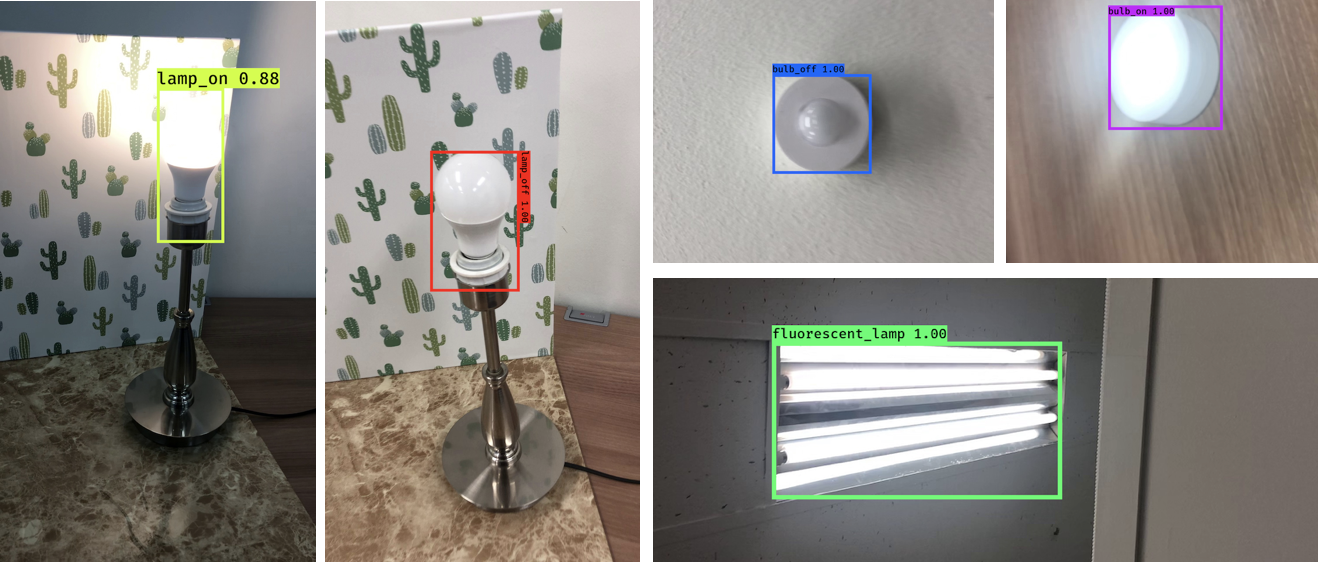

**5.Model Save**

```python 
# yolo.py 파일에 학습된 모델을 반환하는 함수
def get_model(self):
    return self.yolo_model

#학습이 완료된 모델을 저장 
model = yolo.get_model()
model.save('model_data/light_tiny_model.h5')
```